In [1]:
# Analyze fatal law enforcement incidents by type of agencys

In [2]:
import pandas as pd;
from matplotlib import pyplot as plt
# import json

In [3]:
plt.style.use('seaborn-v0_8-white')
pd.set_option('display.max_columns', 100)

In [4]:
incidents_flagged = pd.read_csv(
    '../outputs/incidents_flagged.csv',
    parse_dates=["Date of Incident (month/day/year)"]
)

incidents_flagged.head(3)

/var/folders/gd/sxkdt3vx5qvfqfl79684m85h0000gp/T/ipykernel_14392/1639624735.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  incidents_flagged = pd.read_csv(


,incident_uid,Victim's name,Victim's age,Victim's gender,Victim's race,URL of image of victim,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,County,Agency responsible for death,ori,Cause of death,Media description of the circumstances surrounding the death,Official disposition of death (justified or other),Criminal Charges?,Link to news article or photo of official document,Symptoms of mental illness?,Armed/Unarmed Status,Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database),Alleged Threat Level (Source: WaPo and Review of Cases Not Included in WaPo Database),Threat Level Description,Fleeing (Source: WaPo and Review of Cases Not Included in WaPo Database),Body Camera (Source: WaPo),WaPo ID (If included in WaPo database),Off-Duty Killing?,Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx ),MPV ID,Fatal Encounters ID,Encounter Type,Initial Reported Reason for Encounter,Names of Officers Involved,Race of Officers Involved,Known Past Shootings of Officer(s),Call for Service?,Census Tract Code,HUD UPSAI Geography,NCHS Urban-Rural Classification Scheme Codes (https://www.cdc.gov/nchs/data_access/urban_rural.htm),Median household income ACS Census Tract,Latitude,Longitude,Total Population of Census Tract 2019 ACS 5-Year Estimates,White Non-Hispanic Percent of the Population ACS,Black Non-Hispanic Percent of the Population ACS,Native American Percent of the Population ACS,Asian Percent of the Population ACS,Pacific Islander Percent of the Population ACS,Other/Two or More Race Percent of the Population ACS,Hispanic Percent of the Population ACS,Congressional District,Congressional Representative Full Name (https://ballotpedia.org/United_States_House_of_Representatives),Unnamed: 52,Congressional Representative Party (https://ballotpedia.org/United_States_House_of_Representatives),Officer Prosecuted by (Chief Prosecutor),Prosecutor Race,Prosecutor Gender,Chief Prosecutor Political Party,Chief Prosecutor Term,Officer Prosecuted by (Prosecutor in Court),Special Prosecutor?,Independent Investigation?,Prosecutor Source Link,Killed by Police 2013-24,sheriff_ori,has_sheriff_in_name,sheriff,police_ori,has_police_in_name,police,others
0,0,Dario Agudelo,29,Male,Hispanic,NaN,2024-02-15,62 E Michigan Ave,Battle Creek,MI,NaN,Calhoun,Battle Creek Police Department,MI1323700,Gunshot,"Officers were called to Café Rica, 62 E. Mich...",NaN,NaN,https://www.battlecreekenquirer.com/story/news...,No,Allegedly Armed,gun,attack,used weapon,Not Fleeing,NaN,NaN,NaN,NaN,12724,NaN,None/Unknown,suspicious person,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,False,False,False,False,True,True,False
1,1,Curtis Wallace,36,Male,Unknown race,NaN,2024-02-15,Adams Ave and Newtown Ave,Philadelphia,PA,NaN,Philadelphia,Philadelphia Police Department,PAPEP0000,Gunshot,The ordeal began shortly after 7 p.m. at the i...,NaN,NaN,https://www.nbcphiladelphia.com/news/local/phi...,No,Vehicle,vehicle,attack,used weapon,Car,NaN,NaN,NaN,NaN,12723,NaN,Traffic Stop,traffic stop,NaN,NaN,NaN,Unavailable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,False,False,False,False,True,True,False
2,2,William Lowery,46,Male,Unknown race,NaN,2024-02-14,5th St and Val Vista St,Sheridan,WY,NaN,Sheridan,"Gillette Police Department, Sheridan Police De...",WY0030100;WY0170100;WY0130000,Gunshot,A man allegedly shot a police officer serving ...,NaN,NaN,https://www.seattlepi.com/news/article/a-wyomi...,No,Allegedly Armed,gun,attack,used weapon,Foot,No,10150.0,NaN,NaN,12722,NaN,Other Non-Violent Offense,trespassing,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,False,True,True,False,True,True,False


In [5]:
sheriff_incidents = (
    incidents_flagged
    .assign(
        year = lambda f: f["Date of Incident (month/day/year)"].dt.year,
    )
    [["incident_uid", "State", "year", "sheriff", "police", "others"]]
    .groupby("year")
    .agg(
        total_involved = ("incident_uid", "count"),
        sheriff_involved = ("sheriff", "sum"),
        police_involved = ("police", "sum"),
        others_involved = ("others", "sum"),
    )
    .reset_index()
)

sheriff_incidents.head()

,year,total_involved,sheriff_involved,police_involved,others_involved
0,2013,1077,276,773,48
1,2014,1039,280,735,49
2,2015,1100,293,794,48
3,2016,1065,303,728,58
4,2017,1089,332,757,42


In [6]:
# merge arrests with incidents data to get deaths/arrests
incidents_arrests = (
    pd
    .read_csv(
        "../outputs/arrests_by_year.csv",
    )
    .merge(
        sheriff_incidents,
        on = "year"
    )
    .assign(
        sheriff_incidents_per_arrest = lambda f: f["sheriff_involved"] / f["sheriffs office"] * 100000,
        police_incidents_per_arrest = lambda f: f["police_involved"] / f["local police department"] * 100000,
        other_incidents_per_arrest = lambda f: f["others_involved"] / f["other"] * 100000,
    )
    .set_index("year")
    .sort_index(ascending = False)
)

# primary finding
incidents_arrests.head()

,local police department,sheriffs office,other,total_involved,sheriff_involved,police_involved,others_involved,sheriff_incidents_per_arrest,police_incidents_per_arrest,other_incidents_per_arrest
year,,,,,,,,,,
2022,8259304.0,1549006.0,54961.0,1202,423,798,61,27.307835,9.661831,110.987791
2021,5596708.0,1160712.0,7950.0,1148,357,803,63,30.756984,14.347720,792.452830
2020,7793940.0,1577127.0,60384.0,1160,379,758,82,24.031039,9.725505,135.797562
2019,8372321.0,1606112.0,70784.0,1098,325,744,70,20.235202,8.886425,98.892405
2018,8624655.0,1650045.0,71993.0,1139,329,786,67,19.938850,9.113408,93.064604


In [7]:
# csv of incidents per arrest by year
incidents_arrests.to_csv("../outputs/incident_rate_by_arrest_year.csv", index = True)

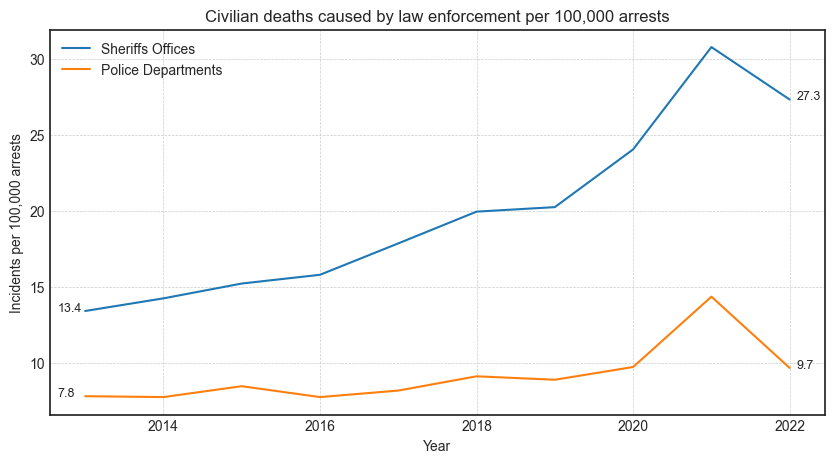

In [8]:
ax = (
    incidents_arrests
    [["sheriff_incidents_per_arrest", "police_incidents_per_arrest"]]
    .plot(
        kind = "line",
        title = "Civilian deaths caused by law enforcement per 100,000 arrests",
        ylabel = "Incidents per 100,000 arrests",
        xlabel = "Year",
        figsize = (10, 5),
    )
)

# annotate beginning and end of both lines with the Y value
for i, y in enumerate(["sheriff_incidents_per_arrest", "police_incidents_per_arrest"]):
    y_13 = incidents_arrests.loc[2013, y]
    y_22 = incidents_arrests.loc[2022, y]
    
    ax.annotate(
        f"{y_13:.1f}",
        xy = (2013, y_13),
        xytext = (-20, 0),
        fontsize = 9,
        # make the text a white border for visibility        
        textcoords = "offset points",
    )

    ax.annotate(
        f"{y_22:.1f}",
        xy = (2022, y_22),
        xytext = (5, 0),
        fontsize = 9,
        textcoords = "offset points",
    )


# legend
ax.legend(["Sheriffs Offices", "Police Departments"])

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

In [9]:
# 2013 to 2022 change
sheriff_2013 = incidents_arrests.query("year == 2013")["sheriff_incidents_per_arrest"].values[0]
sheriff_2022 = incidents_arrests.query("year == 2022")["sheriff_incidents_per_arrest"].values[0]
sheriff_change = (sheriff_2022 - sheriff_2013) / sheriff_2013 * 100
police_2013 = incidents_arrests.query("year == 2013")["police_incidents_per_arrest"].values[0]
police_2022 = incidents_arrests.query("year == 2022")["police_incidents_per_arrest"].values[0]
police_change = (police_2022 - police_2013) / police_2013 * 100


In [10]:
# lethal incidents per 100,000 arrests, 2022
print(f"""
Lethal incidents per 100,000 arrests, 2022.
- Sheriffs Offices: {sheriff_2022:.1f}%
- Police Departments: {police_2022:.1f}% 
"""
)


Lethal incidents per 100,000 arrests, 2022.
- Sheriffs Offices: 27.3%
- Police Departments: 9.7% 



In [11]:
# percent change in lethal incidents per 100,000 arrests, 2013 to 2022

print(f"""
Percent change in lethal incidents per 100,000 arrests:
- Sheriff Offices: {sheriff_change:.0f}%,
- Police Departments: {police_change:.0f}%
""")


Percent change in lethal incidents per 100,000 arrests:
- Sheriff Offices: 104%,
- Police Departments: 24%



---
---
---